In [1]:
import os, glob
import pandas as pd
import numpy as np
from collections import defaultdict
import wave, struct
import matplotlib.pyplot as plt
import pyAudioAnalysis.pyAudioAnalysis.ShortTermFeatures as sF
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
#Flags
use_delta = False
fWindowSize = 0.02
fStepSize = 0.01
Context = (-2,-1,0,1,2)
working_dir = 'egs/BeepDetModel'
egs_dir = os.path.join(working_dir,'egs')
nFeatures = 68 if use_delta else 34

## Feature Extraction

In [2]:
#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = '../../Recordings/Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1

In [7]:
#Load each wav file, split to frames and extract features
testFileNames = ['/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav']
working_dir = 'egs/BeepDetModel'
egs_dir = os.path.join(working_dir,'egs')

os.makedirs(egs_dir)

use_delta = False
fWindowSize = 0.02
fStepSize = 0.01
Context = (-2,-1,0,1,2)

nFeatures = 68 if use_delta else 34

nNonBeepSamples = 3000

#data_beep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float) #Num Features + 1 for file index 
#data_NonBeep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float)


alldata = []
nNonBeepPerFile = int(nNonBeepSamples/len(dBeepTimes))
FileIndx = 0

#Get number of padded rows for context
nPostPad = max(Context)
nPrePad = abs(min(Context))

for sWavFile in dBeepTimes:
    data_beep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float) #Num Features + 1 for file index and (1 or 0) for beep and nonbeep samples 
    data_NonBeep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float)
    iBeepPointer = 0
    iNonBeepPointer = 0

    #if WavFile in testFileNames:
    #   continue
    iCurrSample = 0
    with wave.open(sWavFile) as fWav:
        #Make sure that the sampling size is 16 bit
        assert fWav.getsampwidth() == 2, 'Only 16 bit resolution supported'
        
        iFrameRate = fWav.getframerate()
        nTotalFrames = fWav.getnframes()
        lNonBeepFramesIndxs = []
        
        #Read beep samples
        for fStartTime, fEndTime in dBeepTimes[sWavFile]:
            iStartFram = int(fStartTime * iFrameRate)
            iEndFram = int(fEndTime * iFrameRate)
            
            if iCurrSample <= iStartFram-2*iFrameRate:
                lNonBeepFramesIndxs.append((iCurrSample,iStartFram-iFrameRate))#Get all non Beep samples we leave 1 second before the start of beep
                iCurrSample = iEndFram + iFrameRate
            
            nFrames = iEndFram - iStartFram
            fWav.setpos(iStartFram)
            
            data = fWav.readframes(nFrames)
            data = [ i[0] for i in struct.iter_unpack('h',data)]
            data = np.asarray(data)
            
            aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)
            
            aFeatures = aFeatures.T
            #Handle context
            aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
            aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))
            
            aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]
            
            aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]
            
            aFeatures_beep = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]
            aFeatures_beep = np.c_[aFeatures_beep,np.zeros(aFeatures_beep.shape[0])+FileIndx]
                        
            data_beep[iBeepPointer:iBeepPointer+aFeatures_beep.shape[0]] = aFeatures_beep
            
            iBeepPointer += aFeatures_beep.shape[0]
            print("Processing {0} from fram {1} to {2} samples {3}".format(sWavFile,iStartFram,iEndFram,aFeatures_beep.shape))
        
        #Get Random non-beep samples
        nNonBeepSegments = len(lNonBeepFramesIndxs)
        nNonBeepPerSegment = int(nNonBeepPerFile/nNonBeepSegments)
        lSamples = []
        for iStart, iEnd in lNonBeepFramesIndxs:
            lSamples.extend(np.random.choice(range(iStart,iEnd),nNonBeepPerSegment,replace=False))
        print("{0} NonBeep random samples selected".format(len(lSamples)))
        i = 0
        for iSample in lSamples:
            i += 1
            #print("{0}/{1}".format(i,len(lSamples)))
            fWav.setpos(iSample)
            
            data = fWav.readframes(int(0.5*iFrameRate))
            data = [ i[0] for i in struct.iter_unpack('h',data)]
            data = np.asarray(data)
            
            aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)
            
            aFeatures = aFeatures.T
            #Handle context
            aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
            aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))
            
            aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]
            
            aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]
            
            aFeatures_NonBeep = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]
            aFeatures_NonBeep = np.c_[aFeatures_NonBeep,np.zeros(aFeatures_NonBeep.shape[0])+FileIndx]
            
            data_NonBeep[iNonBeepPointer:iNonBeepPointer+aFeatures_NonBeep.shape[0]] = aFeatures_NonBeep
            
            iNonBeepPointer += aFeatures_NonBeep.shape[0]
    data_beep = data_beep[:iBeepPointer]
    data_NonBeep = data_NonBeep[:iNonBeepPointer]
    data_beep = np.c_[data_beep,np.ones(data_beep.shape[0],dtype=int)]
    data_NonBeep = np.c_[data_NonBeep,np.zeros(data_NonBeep.shape[0],dtype=int)]
    data = np.r_[data_beep, data_NonBeep]

    print("File {2}, Total Number of Beep Samples {0}, Total Number of NonBeep Samples {1}".format(data_beep.shape[0],data_NonBeep.shape[0],sWavFile))
    np.save(os.path.join(egs_dir,'egs_{1}_{0}'.format(FileIndx,len(Context))),data)
          
    FileIndx += 1
    
#data_beep = data_beep[:iBeepPointer]
#data_NonBeep = data_NonBeep[:iNonBeepPointer]
#Add label column


Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav from fram 577710 to 621810 samples (99, 171)
375 NonBeep random samples selected
File /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav, Total Number of Beep Samples 99, Total Number of NonBeep Samples 18375
Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav from fram 1539530 to 1583630 samples (99, 171)
Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav from fram 8574583 to 8618683 samples (99, 171)
Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav from fram 14655223 to 14699323 samples (99, 171)
Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav from fram 46328725 to 46372825 samples (99, 171)
Processing /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/T

## Analyze Features

In [66]:
#Get egs data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)

#Put features without context in DataFram
left_context = abs(min(Context))
right_context = max(Context)
data_NoContxt = np.c_[data[:,left_context*nFeatures:(left_context+1)*nFeatures], data[:,-2:]]
pdData = pd.DataFrame(data=data_NoContxt,columns=lFeatures_names+['FileIndx','label'])

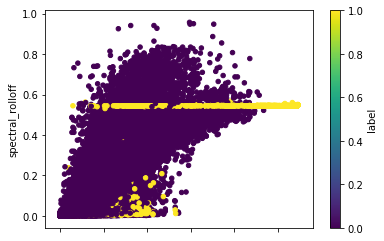

In [68]:
#Plot Data
pdData = pdData.astype({'label':int,'FileIndx':int})
pdData.plot.scatter(lFeatures_names[0],lFeatures_names[7],c='label',colormap='viridis')

## Building Classification Model

In [3]:
#Data Selection
#Load data from numpy pickle
#Get egs data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)
X = data[:,:-2]
y = data[:,-1].astype(int)
groups = data[:,-2].astype(int)

#Split data where one recording out
spliter = LeaveOneGroupOut()
print(spliter.get_n_splits(X,y,groups))
print(X.shape,y.shape)


#Start with random split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

8
(149740, 170) (149740,)


In [4]:
#Data Normalizatio
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [5]:
#Train SVM model simple Linear model
clf = svm.SVC(kernel='rbf',C=100, gamma=1e-3, class_weight='balanced')
clf.fit(X_train_std,y_train)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43906
           1       0.98      0.95      0.96      1016

    accuracy                           1.00     44922
   macro avg       0.99      0.98      0.98     44922
weighted avg       1.00      1.00      1.00     44922

[[43883    23]
 [   50   966]]


In [4]:
#Split where one recording for test and others for training
iSplit=0
for train_index, test_index in spliter.split(X,y,groups):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    print('********Split {0} with {1} training examples and {2} testing examples'.format(iSplit,y_train.shape[0],y_test.shape[0]))
    #Data Normalizatio
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)
    #Train SVM model 
    clf = svm.SVC(kernel='rbf',C=100, gamma=1e-3, class_weight='balanced')
    clf.fit(X_train_std,y_train)
    y_pred = clf.predict(X_test_std)
    print('**************Results of split ',iSplit)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    iSplit += 1

********Split 0 with 131266 training examples and 18474 testing examples
**************Results of split  0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18375
           1       0.87      0.96      0.91        99

    accuracy                           1.00     18474
   macro avg       0.94      0.98      0.96     18474
weighted avg       1.00      1.00      1.00     18474

[[18361    14]
 [    4    95]]
********Split 1 with 130758 training examples and 18982 testing examples
**************Results of split  1
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18081
           1       0.93      0.79      0.86       901

    accuracy                           0.99     18982
   macro avg       0.96      0.90      0.92     18982
weighted avg       0.99      0.99      0.99     18982

[[18026    55]
 [  185   716]]
********Split 2 with 131068 training examples and 18672 testing exampl

In [ ]:
#Parameter Tuning CV with Pipeline
pipeLine = Pipeline([('scaler',StandardScaler()),('svc',svm.SVC(class_weight='balanced'))])
tuned_parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 1e-4],
                     'svc__C': [1, 10, 100, 1000]}]
score = 'recall'
print("# Tuning hyper-parameters for {0}\n".format(score))

cv = spliter.split(X,y,groups)

clf = GridSearchCV(pipeLine, param_grid=tuned_parameters, 
                   scoring="{0}_macro".format(score), n_jobs=3, verbose=5, cv=cv)

clf.fit(X, y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
#print()
#print("Detailed classification report:")
#print()
#print("The model is trained on the full development set.")
#print("The scores are computed on the full evaluation set.")
#print()
#y_true, y_pred = y_test, clf.predict(X)
#print(classification_report(y_true, y_pred))
#print()

# Tuning hyper-parameters for recall

Fitting 8 folds for each of 8 candidates, totalling 64 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 63.6min


In [ ]:
#Parameter Tuning (random CV splitting, no pipeline)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10]}]
score = 'recall'
print("# Tuning hyper-parameters for {0}\n".format(score))

clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid=tuned_parameters, 
                   scoring="{0}_macro".format(score), n_jobs=3, verbose=5)

clf.fit(X_train_std, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()

## Build Model With Best Param

In [ ]:
#Best param kernel 'rbf', gamma = 0.001, C = 1000
#Train the model
clf = svm.SVC(kernel='rbf', C=1000, gamma=0.001, class_weight='balanced')
clf.fit(X_train_std, y_train)

#Test the model
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

## Test Beep Time Detection

In [5]:
#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = '../../Recordings/Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1

In [96]:
nChunkSize = 1000 #Number of frames to read each time

testFileName = '/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav'#'/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav'
with wave.open(testFileName) as fWav:
    iFrameRate = fWav.getframerate()
    nSamples = fWav.getnframes()
    nFrames = int(nSamples / (fStepSize * iFrameRate))
    print("file {0} contains {1} frames".format(testFileName,nFrames))
    aBeepMask = np.zeros(nFrames,dtype=int)
    i = 0
    while fWav.tell() < nSamples:
        print(nChunkSize,fStepSize,iFrameRate)
        data = fWav.readframes(int(nChunkSize*fStepSize*iFrameRate))
        data = [ x[0] for x in struct.iter_unpack('h',data)]
        data = np.asarray(data)
        aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)
        X = aFeatures.T
        X_std = scaler.transform(X)
        y_pred = clf.predict(X_std)
        aBeepMask[i:i+y_pred.shape[0]] = y_pred
        i = i+y_pred.shape[0]
        print(fWav.tell(),data.shape,aFeatures.shape,y_pred.shape,np.where(y_pred==1)[0].shape)
    

file /media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav contains 302459 frames
1000 0.01 44100
441000 (441000,) (34, 999) (999,) (235,)
1000 0.01 44100
882000 (441000,) (34, 999) (999,) (333,)
1000 0.01 44100
1323000 (441000,) (34, 999) (999,) (142,)
1000 0.01 44100
1764000 (441000,) (34, 999) (999,) (15,)
1000 0.01 44100
2205000 (441000,) (34, 999) (999,) (159,)
1000 0.01 44100
2646000 (441000,) (34, 999) (999,) (141,)
1000 0.01 44100
3087000 (441000,) (34, 999) (999,) (255,)
1000 0.01 44100
3528000 (441000,) (34, 999) (999,) (12,)
1000 0.01 44100
3969000 (441000,) (34, 999) (999,) (0,)
1000 0.01 44100
4410000 (441000,) (34, 999) (999,) (1,)
1000 0.01 44100
4851000 (441000,) (34, 999) (999,) (108,)
1000 0.01 44100
5292000 (441000,) (34, 999) (999,) (42,)
1000 0.01 44100
5733000 (441000,) (34, 999) (999,) (129,)
1000 0.01 44100
6174000 (441000,) (34, 999) (999,) (101,)
1000 0.01 44100
6615000 (441000,) (34, 999) (999,) (41,)
1000 0.01 44100
7056000 (441

61299000 (441000,) (34, 999) (999,) (241,)
1000 0.01 44100
61740000 (441000,) (34, 999) (999,) (282,)
1000 0.01 44100
62181000 (441000,) (34, 999) (999,) (289,)
1000 0.01 44100
62622000 (441000,) (34, 999) (999,) (7,)
1000 0.01 44100
63063000 (441000,) (34, 999) (999,) (238,)
1000 0.01 44100
63504000 (441000,) (34, 999) (999,) (247,)
1000 0.01 44100
63945000 (441000,) (34, 999) (999,) (328,)
1000 0.01 44100
64386000 (441000,) (34, 999) (999,) (305,)
1000 0.01 44100
64827000 (441000,) (34, 999) (999,) (270,)
1000 0.01 44100
65268000 (441000,) (34, 999) (999,) (333,)
1000 0.01 44100
65709000 (441000,) (34, 999) (999,) (276,)
1000 0.01 44100
66150000 (441000,) (34, 999) (999,) (304,)
1000 0.01 44100
66591000 (441000,) (34, 999) (999,) (290,)
1000 0.01 44100
67032000 (441000,) (34, 999) (999,) (214,)
1000 0.01 44100
67473000 (441000,) (34, 999) (999,) (382,)
1000 0.01 44100
67914000 (441000,) (34, 999) (999,) (180,)
1000 0.01 44100
68355000 (441000,) (34, 999) (999,) (149,)
1000 0.01 44100

123039000 (441000,) (34, 999) (999,) (209,)
1000 0.01 44100
123480000 (441000,) (34, 999) (999,) (167,)
1000 0.01 44100
123921000 (441000,) (34, 999) (999,) (225,)
1000 0.01 44100
124362000 (441000,) (34, 999) (999,) (322,)
1000 0.01 44100
124803000 (441000,) (34, 999) (999,) (157,)
1000 0.01 44100
125244000 (441000,) (34, 999) (999,) (195,)
1000 0.01 44100
125685000 (441000,) (34, 999) (999,) (286,)
1000 0.01 44100
126126000 (441000,) (34, 999) (999,) (299,)
1000 0.01 44100
126567000 (441000,) (34, 999) (999,) (298,)
1000 0.01 44100
127008000 (441000,) (34, 999) (999,) (226,)
1000 0.01 44100
127449000 (441000,) (34, 999) (999,) (248,)
1000 0.01 44100
127890000 (441000,) (34, 999) (999,) (451,)
1000 0.01 44100
128331000 (441000,) (34, 999) (999,) (244,)
1000 0.01 44100
128772000 (441000,) (34, 999) (999,) (368,)
1000 0.01 44100
129213000 (441000,) (34, 999) (999,) (298,)
1000 0.01 44100
129654000 (441000,) (34, 999) (999,) (211,)
1000 0.01 44100
130095000 (441000,) (34, 999) (999,) (16

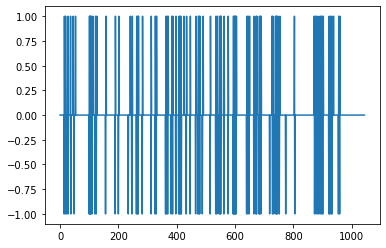

In [63]:
plt.plot(aBeepMask-np.roll(aBeepMask,-1))

In [97]:
suma=np.sum(aBeepMask[:100])
vSum = np.zeros(aBeepMask.shape[0]-100)
for i in range(aBeepMask.shape[0]-100):
    vSum[i] = suma
    suma = suma - aBeepMask[i] + aBeepMask[i+100]

In [98]:
np.where(vSum>95)

(array([ 10332,  10333,  10334,  10335,  10336,  10337,  10338,  10339,
         10340,  10341,  50150,  50151,  50152,  50153,  50154,  50155,
         50156,  50157,  50158,  50159,  50160,  50161,  50162, 122171,
        122172, 122173, 122174, 122175, 122176, 122177, 122178, 122179,
        122180, 122181, 122182, 122183, 122184, 122185, 122186, 122187,
        122188, 221530, 221531, 221532, 221533, 221534, 221535, 221536,
        221537, 221538, 268018, 268019, 268020, 268021, 268022, 268023,
        268024, 268025, 268026, 268027, 268028, 268029, 268030, 268031]),)

In [82]:
dBeepTimes[testFileName]

[(30.66, 31.66),
 (552.8480000000001, 553.8480000000001),
 (1334.75, 1335.75),
 (2225.89, 2226.89),
 (2248.935, 2249.935),
 (2744.7090000000003, 2745.7090000000003),
 (3403.236, 3404.236)]

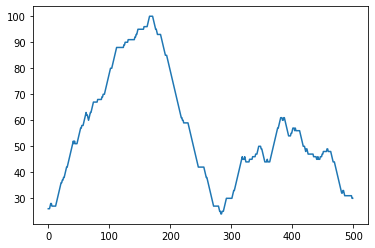

In [95]:
plt.plot(vSum[222200:222700])

In [90]:
aBeepMask.shape
vSum.shape

(370660,)

In [4]:
f = wave.open('egs/Beeps/Sample1.wav')

In [6]:
f.getnframes()

1343414

In [7]:
d = f.readframes(10)

In [8]:
f.tell()

10

In [9]:
d

b'N\x00I\x00H\x00<\x00>\x002\x004\x004\x00/\x001\x00'

In [23]:
data = [i[0] for i in struct.iter_unpack('h',d)]

In [24]:
data

[78, 73, 72, 60, 62, 50, 52, 52, 47, 49]

In [12]:
f.setpos(5)

In [13]:
f.tell()

5

In [58]:
import numpy

In [17]:
data_beep.shape

(2437, 34)

In [19]:
data_beep = data_beep[:,:34]

In [38]:
pdData.to_pickle('Beep_NonBeep.gzip',compression='gzip')

In [29]:
pdData = pdData.rename(columns={'lable':'label'})

In [37]:
pdData

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std,label
0,0.026107,0.023881,2.952514,0.149147,0.239787,0.127924,0.000000,0.022676,-24.828048,2.665265,...,0.022029,0.021238,0.000235,0.000314,0.008918,0.001560,0.198840,0.000447,0.053615,1
1,0.039728,0.010181,2.792336,0.125940,0.235431,0.074945,0.009646,0.022676,-26.299752,3.146192,...,0.018564,0.011332,0.000123,0.000949,0.004107,0.000762,0.146623,0.000438,0.039614,1
2,0.057889,0.018654,1.944444,0.340922,0.255146,1.439361,0.020274,0.562358,-25.740006,2.078188,...,0.004672,0.028268,0.000302,0.002667,0.008031,0.001571,0.071698,0.000468,0.020861,1
3,0.150965,0.034977,2.674830,0.346859,0.256991,1.176551,0.004105,0.546485,-25.984883,2.449404,...,0.000302,0.022524,0.000113,0.000931,0.001405,0.001999,0.153657,0.000235,0.042105,1
4,0.357548,0.034518,3.145192,0.313703,0.266910,1.087860,0.008439,0.544218,-26.793118,2.463520,...,0.001661,0.010340,0.000085,0.000150,0.002542,0.001178,0.132129,0.000050,0.035941,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44030,0.011351,0.149749,2.540470,0.134250,0.241330,0.050390,0.028181,0.009070,-23.830157,2.753325,...,0.000216,0.005289,0.000099,0.000412,0.001147,0.000189,0.241018,0.000177,0.066119,0
44031,0.015891,0.069312,2.959871,0.137631,0.261177,0.035866,0.006084,0.009070,-25.840094,3.149468,...,0.000834,0.013769,0.000023,0.000090,0.002541,0.000063,0.219121,0.000074,0.060025,0
44032,0.017026,0.179122,2.612994,0.114428,0.233535,0.022877,0.010135,0.009070,-24.292798,3.310984,...,0.000163,0.012701,0.000034,0.000190,0.001060,0.000047,0.252514,0.000056,0.069179,0
44033,0.017026,0.180206,2.685020,0.111079,0.237368,0.018542,0.012567,0.009070,-25.440577,3.170213,...,0.000059,0.039243,0.000014,0.000083,0.000050,0.000163,0.209545,0.000077,0.057598,0


In [47]:
sklearn.__version__

'0.22.1'

In [24]:
fWav.getsampwidth()

3

In [25]:
import scipy

In [26]:
fr, data = scipy.io.wavfile.read('egs/Beeps/Sample1.wav')

AttributeError: module 'scipy' has no attribute 'io'

In [27]:
scipy.__version__

'1.4.1'

In [31]:
dBeepTimes

defaultdict(list,
            {'/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav': [(13.1,
               14.1)],
             '/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav': [(34.91,
               35.91),
              (194.435, 195.435),
              (332.31800000000004, 333.31800000000004),
              (1050.538, 1051.538),
              (1065.531, 1066.531),
              (1268.032, 1269.032),
              (1357.734, 1358.734),
              (1392.733, 1393.8329999999999),
              (1422.634, 1423.634)],
             '/media/Windows/root/AusKidTalk/Recordings/10_March_2020/Audio 1_01-01.wav': [(7.21,
               8.21),
              (279.3, 280.3),
              (380.62, 381.62)],
             '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/child_2_2/Primary_03-01.wav': [(462.639,
               463.639),
              (598.61, 599.61)],
             '/media/Windows/root/AusKidTalk/Recordi

In [10]:
2680.18 % 60

40.179999999999836

In [11]:
2680.18/60

44.669666666666664

In [47]:
a = np.arange(1,41)

In [48]:
a = a.reshape(10,4)

In [49]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40]])

In [26]:
a[0]

array([1, 2, 3, 4])

In [29]:
np.r_[a[0],a[1],a[2]]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [31]:
i=2

In [32]:
c = (-1,0,1)

In [37]:
np.roll(a,-1,axis=0)

array([[ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40],
       [ 1,  2,  3,  4]])

In [45]:
np.c_[np.roll(a,1,axis=0),np.roll(a,0,axis=0),np.roll(a,-1,axis=0)]

array([[37., 38., 39., 40.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.],
       [ 0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
       [13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
       [17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
       [21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.],
       [25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.],
       [29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.],
       [33., 34., 35., 36., 37., 38., 39., 40.,  0.,  0.,  0.,  0.]])

In [43]:
a = np.r_[np.zeros((1,a.shape[1])),a]

In [56]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40]])

In [117]:
c = (-2,-1,0,1,2)

In [118]:
max(c)

2

In [119]:
min(c)

-2

In [120]:
nPostPad = max(c)
nPrePad = abs(min(c))

In [121]:
aPostPad = np.zeros((nPostPad,a.shape[1]))
aPrePad = np.zeros((nPrePad,a.shape[1]))

In [122]:
aPostPad.shape

(2, 4)

In [123]:
a_pad = np.r_[aPrePad,a,aPostPad]

In [124]:
a_pad.shape

(14, 4)

In [125]:
xx = [np.roll(a_pad,i,axis=0) for i in c[::-1]]

In [126]:
np.concatenate(xx,axis=1)[0+nPrePad:-nPostPad].shape

(10, 20)

In [7]:
list(dBeepTimes.keys())

['/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/10_March_2020/Audio 1_01-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/child_2_2/Primary_03-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/Child1/Primary_01-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/Child2/Primary_02-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav',
 0]

In [1]:
f = '/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav'

In [14]:
z = np.load('egs/BeepDetModel/egs/egs_5_1.npy')

In [15]:
z.shape

(18982, 172)

In [19]:
np.where(z[:,-1]==0)[0].shape

(18081,)

In [24]:
xx = [np.load('egs/BeepDetModel/egs/egs_{0}.npy'.format(i)) for i in range(8)]

In [25]:
xx

[array([[0.        , 0.        , 0.        , ..., 0.03961403, 0.        ,
         1.        ],
        [0.0261067 , 0.023881  , 2.95251418, ..., 0.02086051, 0.        ,
         1.        ],
        [0.03972758, 0.01018135, 2.79233571, ..., 0.04210504, 0.        ,
         1.        ],
        ...,
        [0.03632236, 0.08585858, 3.16158758, ..., 0.02501251, 0.        ,
         0.        ],
        [0.05561862, 0.06888916, 3.11556522, ..., 0.03855069, 0.        ,
         0.        ],
        [0.05107832, 0.0576163 , 3.19697933, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.34946135e-03, 1.00000000e+00, 1.00000000e+00],
        [5.44835414e-01, 2.68381203e-01, 3.28015702e+00, ...,
         1.64341840e-03, 1.00000000e+00, 1.00000000e+00],
        [5.44835414e-01, 3.43247403e-01, 3.31031953e+00, ...,
         1.86870431e-03, 1.00000000e+00, 1.00000000e+00],
        ...,
        [3.17820658e-02, 8.00373653e

In [26]:
c = np.concatenate(xx,axis=0)

In [27]:
c.shape

(51348, 104)

In [31]:
c[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.61066969e-02,  2.38809978e-02,
        2.95251418e+00,  1.49146586e-01,  2.39787433e-01,  1.27923699e-01,
        0.00000000e+00,  2.26757370e-02, -2.48280482e+01,  2.66526479e+00,
        1.05931726e-01,  1.07515522e-01,  1.66281890e-01,  2.73602186e-01,
        2.19841888e-01,  1.37654325e-01, -9.98709153e-02, -4.28346715e-02,
       -1.32253766e-01, -

In [32]:
c.shape

(51348, 104)

In [33]:
c[:,2*nFeatures:3*nFeatures].shape

(51348, 34)

In [38]:
mask = np.zeros(c.shape,dtype=bool)

In [62]:
data_NoContxt.shape

(149740, 36)

In [63]:
lFeatures_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std']

In [65]:
len(lFeatures_names+['f','g'])

36

In [7]:
list(spliter.split(X,y,groups))

[(array([ 18474,  18475,  18476, ..., 149737, 149738, 149739]),
  array([    0,     1,     2, ..., 18471, 18472, 18473])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([18474, 18475, 18476, ..., 37453, 37454, 37455])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([37456, 37457, 37458, ..., 56125, 56126, 56127])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([56128, 56129, 56130, ..., 74649, 74650, 74651])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([74652, 74653, 74654, ..., 93173, 93174, 93175])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([ 93176,  93177,  93178, ..., 111995, 111996, 111997])),
 (array([     0,      1,      2, ..., 149737, 149738, 149739]),
  array([111998, 111999, 112000, ..., 130867, 130868, 130869])),
 (array([     0,      1,      2, ..., 130867, 130868, 130869]),
  array([130870, 130871, 130872, ..., 149737, 149738, 149739]))